In [1]:
import numpy as np
# scipy.special for the sigmoid function expit()
import scipy.special
import pandas as pd
import cv2 as cv
import os
from keras.models import Sequential

from keras.layers import Dense


2023-06-05 22:18:22.549629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Phase 1 (Loading , Cleaning and Pre-processing dataset)

def load_images_from_folder(folder):

    images = []
    for filename in os.listdir(folder):
        # Data(Image) Collection
        img = cv.imread(os.path.join(folder,filename) , 0)
        if img is not None:
            # Image Pre-processing
            ## Resizing
            resizedImage = cv.resize(img, (28, 28), interpolation=cv.INTER_AREA)

            ## making pixels lie in the range [0,1]

            # resizedImage = resizedImage // 255
            resizedImage = cv.normalize(resizedImage, None, 0.01, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    
            images.append(resizedImage)
            

    return np.array(images)

def loadDataSet(folder):

    dataSet = np.zeros((0, 28, 28), dtype=int)
    dataSetLabels = np.zeros((0), dtype=int)

    for i in range(0,10):

        folderName = folder + "/" + str(i) + "/"
        ans = load_images_from_folder(folderName)
        #print(len(ans))
        dataSet = np.concatenate((dataSet,ans))
        dataSetLabels = np.concatenate((dataSetLabels, np.full( (len(ans)) , i) ))

    return (dataSet, dataSetLabels)


if __name__ == '__main__':
    
    # -------------- Training Set (60,000) ---------------------
    print("Loading Training Set...\n")
    trainingSet ,trainingSetLabels = loadDataSet("TrainingSet")
    trainingSet_2D = trainingSet.reshape((60000,784))
    
    print(len(trainingSet))
    print(len(trainingSetLabels))
    


    
    # # -------------------- Testing Set (10,000) ------------------
    print("Loading Testing Set...\n")
    testingSet ,testingSetLabels = loadDataSet("TestingSet")
    testingSet_2D = testingSet.reshape((10000,784))


    print(len(testingSet))
    print(len(testingSetLabels))
    
    


    #----------------- Storing  training set to to csv --------------------
    
    print("Storing training data to csv...")
    # convert the 2D numpy array to a 2D pandas DataFrame
    trainSet_df = pd.DataFrame(trainingSet_2D)
    
    # add a 'Label' column to the DataFrame
    trainSet_df['Label'] = pd.Series(trainingSetLabels)
    
    trainSet_df.to_csv('Training_Set.csv')

    ## ----------------  Storing  testing set to to csv--------------------
   
    print("Storing testing data to csv...")
    # convert the 2D numpy array to a 2D pandas DataFrame
    testSet_df = pd.DataFrame(testingSet_2D)

    # add a 'Label' column to the DataFrame
    testSet_df['Label'] = pd.Series(testingSetLabels)
    
    testSet_df.to_csv('Testing_Set.csv')


Loading Training Set...

60000
60000
Loading Testing Set...

10000
10000
Storing training data to csv...
Storing testing data to csv...


In [6]:
# From this point onwards (Phase 2)

class neuralNetwork:
    
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass

    
    # train the neural network
    def train(self, inputs_list, targets_list):
        
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors) 
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
        pass

    
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [7]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [63]:
df = pd.read_csv('Training_Set.csv')
df.drop(['Unnamed: 0'], axis =1, inplace=True)
df = df.sample(frac=1)


In [64]:
labels = df['Label']
labels
df.drop(['Label'],inplace=True,axis=1)

In [66]:
labels = labels.to_numpy()
inputData = df.to_numpy()

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(inputData,labels,test_size = 0.1)
print(labels.shape)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(60000,)
(54000, 784) (6000, 784) (54000,) (6000,)


In [11]:
df1 = pd.read_csv('Testing_Set.csv')
df1.drop(['Unnamed: 0'], axis =1, inplace=True)
df1 = df1.sample(frac=1)

In [12]:
labels_test = df1['Label']
df1.drop(['Label'],inplace=True,axis=1)

In [13]:
labels_test = labels_test.to_numpy()
testingData = df1.to_numpy()

In [16]:
# test the neural network

def test(epochNum):
    itr = 0
    rightsAns = 0
    y_test = []
    y_pred = []
    
    # go through all the records in the test data set
    for record in testingData:
        # correct answer is first value
        correct_label = int(labels_test[itr])
        y_test.append(correct_label)
        
        itr += 1
        # query the network
        outputs = n.query(record)
        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)
        y_pred.append(label)
       
        # append correct or incorrect to list
        if (label == correct_label):
            rightsAns += 1
    
    y_test = np.array(y_test)
    y_test = to_categorical(y_test, num_classes=10)
    y_pred = np.array(y_pred)
    num_classes = 10
    labels = range(num_classes)
    loss = log_loss(y_pred,y_test,labels=labels)
    
    print ("Epoch = ",epochNum," Performance = ", rightsAns/10000, "Loss = ",loss )
    return rightsAns/10000, loss
    

In [53]:
# train the neural network

epochs = 5
# acc = []
# ep = []
# loss = []

# for e in range(epochs):
    
#     # go through all records in the training data set
#     itr = 0
#     for record in inputData:
        
#         # create the target output values (all 0.01, except the desired label which is 0.99)
#         targets = np.zeros(output_nodes) + 0.01
#         # all_values[0] is the target label for this record
#         targets[int(labels[itr])] = 0.99
#         itr += 1
#         n.train(record, targets)
        
#     a , l = test(e)
#     acc.append(a)
#     loss.append(l)
#     ep.append(e)

import tensorflow as tf
# l1 = np.full((60000,10), 0.0)
# for i in range(0,60000):
#     l1[i][int(labels[i])] = 1.0
    

# l2 = np.full((10000,10), 0.0)
# for i in range(0,10000):
#     l2[i][int(labels_test[i])] = 1.0

model = Sequential()
model.add(Dense(200, input_dim=784, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.1), metrics=["accuracy"])
model.fit(inputData, l1, epochs=15, batch_size=300)

    

Epoch 1/15
200/200 [==============================] - 2s 7ms/step - loss: 0.6115 - accuracy: 0.8366
Epoch 2/15
200/200 [==============================] - 1s 7ms/step - loss: 0.2794 - accuracy: 0.9165
Epoch 3/15
200/200 [==============================] - 1s 7ms/step - loss: 0.2511 - accuracy: 0.9254
Epoch 4/15
200/200 [==============================] - 1s 7ms/step - loss: 0.2383 - accuracy: 0.9288
Epoch 5/15
200/200 [==============================] - 1s 7ms/step - loss: 0.2232 - accuracy: 0.9338
Epoch 6/15
200/200 [==============================] - 1s 6ms/step - loss: 0.2070 - accuracy: 0.9377
Epoch 7/15
200/200 [==============================] - 1s 6ms/step - loss: 0.2089 - accuracy: 0.9371
Epoch 8/15
200/200 [==============================] - 1s 6ms/step - loss: 0.2076 - accuracy: 0.9386
Epoch 9/15
200/200 [==============================] - 1s 6ms/step - loss: 0.2047 - accuracy: 0.9396
Epoch 10/15
200/200 [==============================] - 1s 6ms/step - loss: 0.1919 - accuracy: 0.9432

In [45]:

# l2 = np.full((10000,10), 0.0)
# for i in range(0,10000):
#     l2[i][int(labels_test[i])] = 1.0

# score = model.evaluate(testingData,l2, verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

Test loss: 0.07372237741947174
Test accuracy: 0.9775000214576721


In [47]:
# y_pred = model.predict(testingData)
# y_pred

313/313 [==============================] - 1s 2ms/step


array([[5.62261557e-04, 4.74831154e-07, 9.98793364e-01, ...,
        3.84708292e-05, 6.05745554e-05, 7.57896785e-08],
       [3.93850907e-09, 2.31297506e-07, 6.52516219e-09, ...,
        2.21254195e-05, 2.04036027e-07, 9.99810219e-01],
       [3.20106096e-07, 6.44433430e-06, 1.05768027e-06, ...,
        2.86826889e-07, 1.35337643e-03, 2.72524776e-03],
       ...,
       [2.94490183e-05, 1.09816703e-03, 6.35232500e-05, ...,
        3.95258069e-02, 1.20448494e-04, 9.57588613e-01],
       [2.04937987e-05, 1.88156027e-05, 4.26582774e-05, ...,
        3.03850061e-06, 2.07016237e-05, 3.66298736e-05],
       [9.55167767e-09, 3.46375804e-04, 2.28538283e-05, ...,
        6.47962734e-04, 2.77334196e-03, 3.02277319e-03]], dtype=float32)

In [51]:
print(labels_test[0])
np.argmax(y_pred[0])

2


2

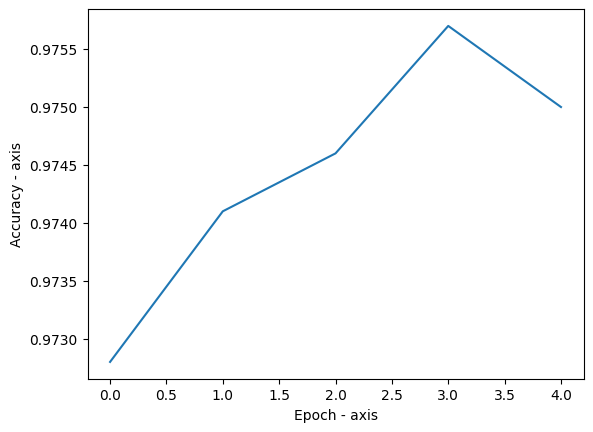

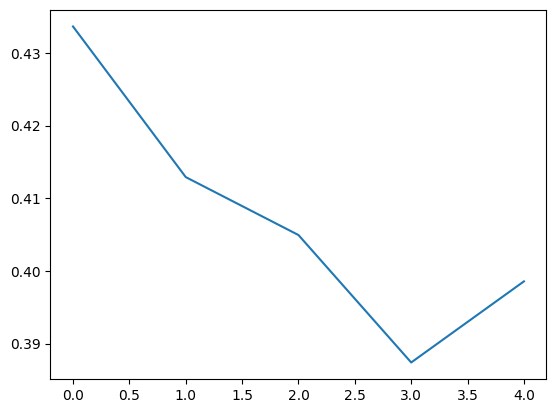

In [20]:
import matplotlib.pyplot as plt


plt.xlabel('Epoch - axis') 
# naming the y axis 
plt.ylabel('Accuracy - axis')

plt.plot(ep, acc)
plt.show()
plt.plot(ep, loss)
plt.show()

# Code Below is just for testing purpose

In [13]:
def predict(Img):
    # query the network
    outputs = n.query(Img)
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    print(label)

In [14]:
import matplotlib.pyplot as py
img = cv.imread("./uploads/37.jpg" , 0)
# inverted_img = cv.bitwise_not(img)
# Resizing
resizedImage = cv.resize(img, (28, 28), interpolation=cv.INTER_AREA)
resizedImage = cv.normalize(resizedImage, None, 0.01, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)

In [15]:
finalImg = resizedImage.reshape((1,784))[0]

In [16]:
predict(finalImg)

1
